In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
epochs = 40
batch_size = 1024
start_learning_rate = 0.001
k_folds = 20  # specify the number of folds
kf = KFold(n_splits=k_folds)

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

decrease_interval = 4
lr_decay = 0.8

num_features = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float)  # Convert to PyTorch tensor once
        self.labels = torch.tensor(labels.values, dtype=torch.float)  # Convert to PyTorch tensor once

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [4]:
print("Loading data...")

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Loading data...


In [5]:
scaler = StandardScaler()

correlated_columns = []

# 2. Preprocess data
def preprocess(df, test=False):
    df = df.drop(columns=["id"])

    # Feature engineering
    
    # Verify all columns besides defects are numeric
    for col in df.columns:
        if col != "defects":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Combine loc and IOCode into a new feature that is the average of the two, and then drop the two features
    df["total_loc"] = (df["loc"] + df["lOCode"]) / 2
    
    # Calculate ratio of comments to lines of code
    df["ratio_comments_loc"] = df["lOComment"] / df["total_loc"] 

    #Calculate ratio of lines of code to branch count
    df["ratio_loc_branch"] = df["total_loc"] / df["branchCount"]

    #Calculate ratio of lines of code to cyclomatic complexity
    df["ratio_loc_cyclo"] = df["total_loc"] / df["v(g)"]

    # Calculate ratio of cyclomatic complexity to essential complexity
    df["ratio_cyclo_essential"] = df["v(g)"] / df["ev(g)"]

    # Calculate ratio of lines of code to essential complexity
    df["ratio_loc_essential"] = df["total_loc"] / df["ev(g)"]

    # Calculate ratio of lines of code to maintainability index
    df["ratio_loc_maintainability"] = df["total_loc"] / df["b"]

    # Calculate ratio of lines of code to McCabe's cyclomatic complexity
    df["ratio_loc_mccabe_cyclo"] = df["total_loc"] / df["lOCode"]

    # Calculate ratio of lines of code to McCabe's essential complexity
    df["ratio_loc_mccabe_essential"] = df["total_loc"] / df["lOComment"]

    # Calculate ratio of lines of code to McCabe's maintainability index
    df["ratio_loc_mccabe_maintainability"] = df["total_loc"] / df["lOBlank"]

    # Calcuulate ratio of lines of code to Halstead difficulty
    df["ratio_loc_halstead_difficulty"] = df["total_loc"] / df["d"] 

    # Fill missing values with 0
    df = df.fillna(-1)
    df = df.replace([np.inf, -np.inf], -1)

    # Scale all features    
    # If not test data, do a fit_transform on the training data
    if not test:
        X_train = df.drop(columns=["defects"])
        y_train = df["defects"]
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

        return X_train, y_train
    # If test data, do a transform on the test data
    else:
        df = pd.DataFrame(scaler.transform(df), columns=df.columns)    
        return df, None


In [6]:
print("Preprocessing training data...")
X_train, y_train = preprocess(train)

# Recombine X_train and y_train into a single dataframe for analysis
train_df = pd.concat([X_train, y_train], axis=1)

#Change y_train to 1 if y_train > 0 using pandas
y_train = y_train.apply(lambda x: 1 if x > 0 else 0)

test_ids = test["id"]

Preprocessing training data...


In [7]:
train_df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,ratio_loc_branch,ratio_loc_cyclo,ratio_cyclo_essential,ratio_loc_essential,ratio_loc_maintainability,ratio_loc_mccabe_cyclo,ratio_loc_mccabe_essential,ratio_loc_mccabe_maintainability,ratio_loc_halstead_difficulty,defects
0,-0.281083,-0.315497,-0.398386,-0.270814,-0.214179,-0.204323,-0.515843,0.416261,-0.582895,-0.080835,...,-0.054964,-0.010866,0.044460,0.058868,0.066270,0.112386,1.154937,2.112539,-0.465619,False
1,-0.427603,-0.442066,-0.398386,-0.270814,-0.377782,-0.304545,0.283395,-0.473180,-0.282763,-0.104512,...,-0.033468,-0.041122,-0.191030,-0.193175,0.224504,0.097168,-0.344434,0.997053,0.091140,False
2,-0.482548,-0.442066,-0.398386,-0.270814,-0.301824,-0.268048,-0.016319,-0.398824,-0.210574,-0.100223,...,-0.114080,-0.222658,-0.191030,-0.301194,-0.318012,0.169929,-0.344434,0.518987,-0.336314,False
3,-0.537492,-0.568635,-0.398386,-0.451499,-0.430368,-0.349603,0.782918,-0.597106,-0.424954,-0.106942,...,0.114322,-0.071378,-0.426519,-0.427216,-0.012847,0.614580,-0.344434,-0.516822,-0.362618,True
4,-0.482548,-0.442066,-0.398386,-0.270814,-0.465426,-0.375627,0.683014,-0.570197,-0.662084,-0.107508,...,-0.127516,-0.252914,-0.191030,-0.319197,1.173905,0.309677,-0.344434,-0.277789,-0.040949,False


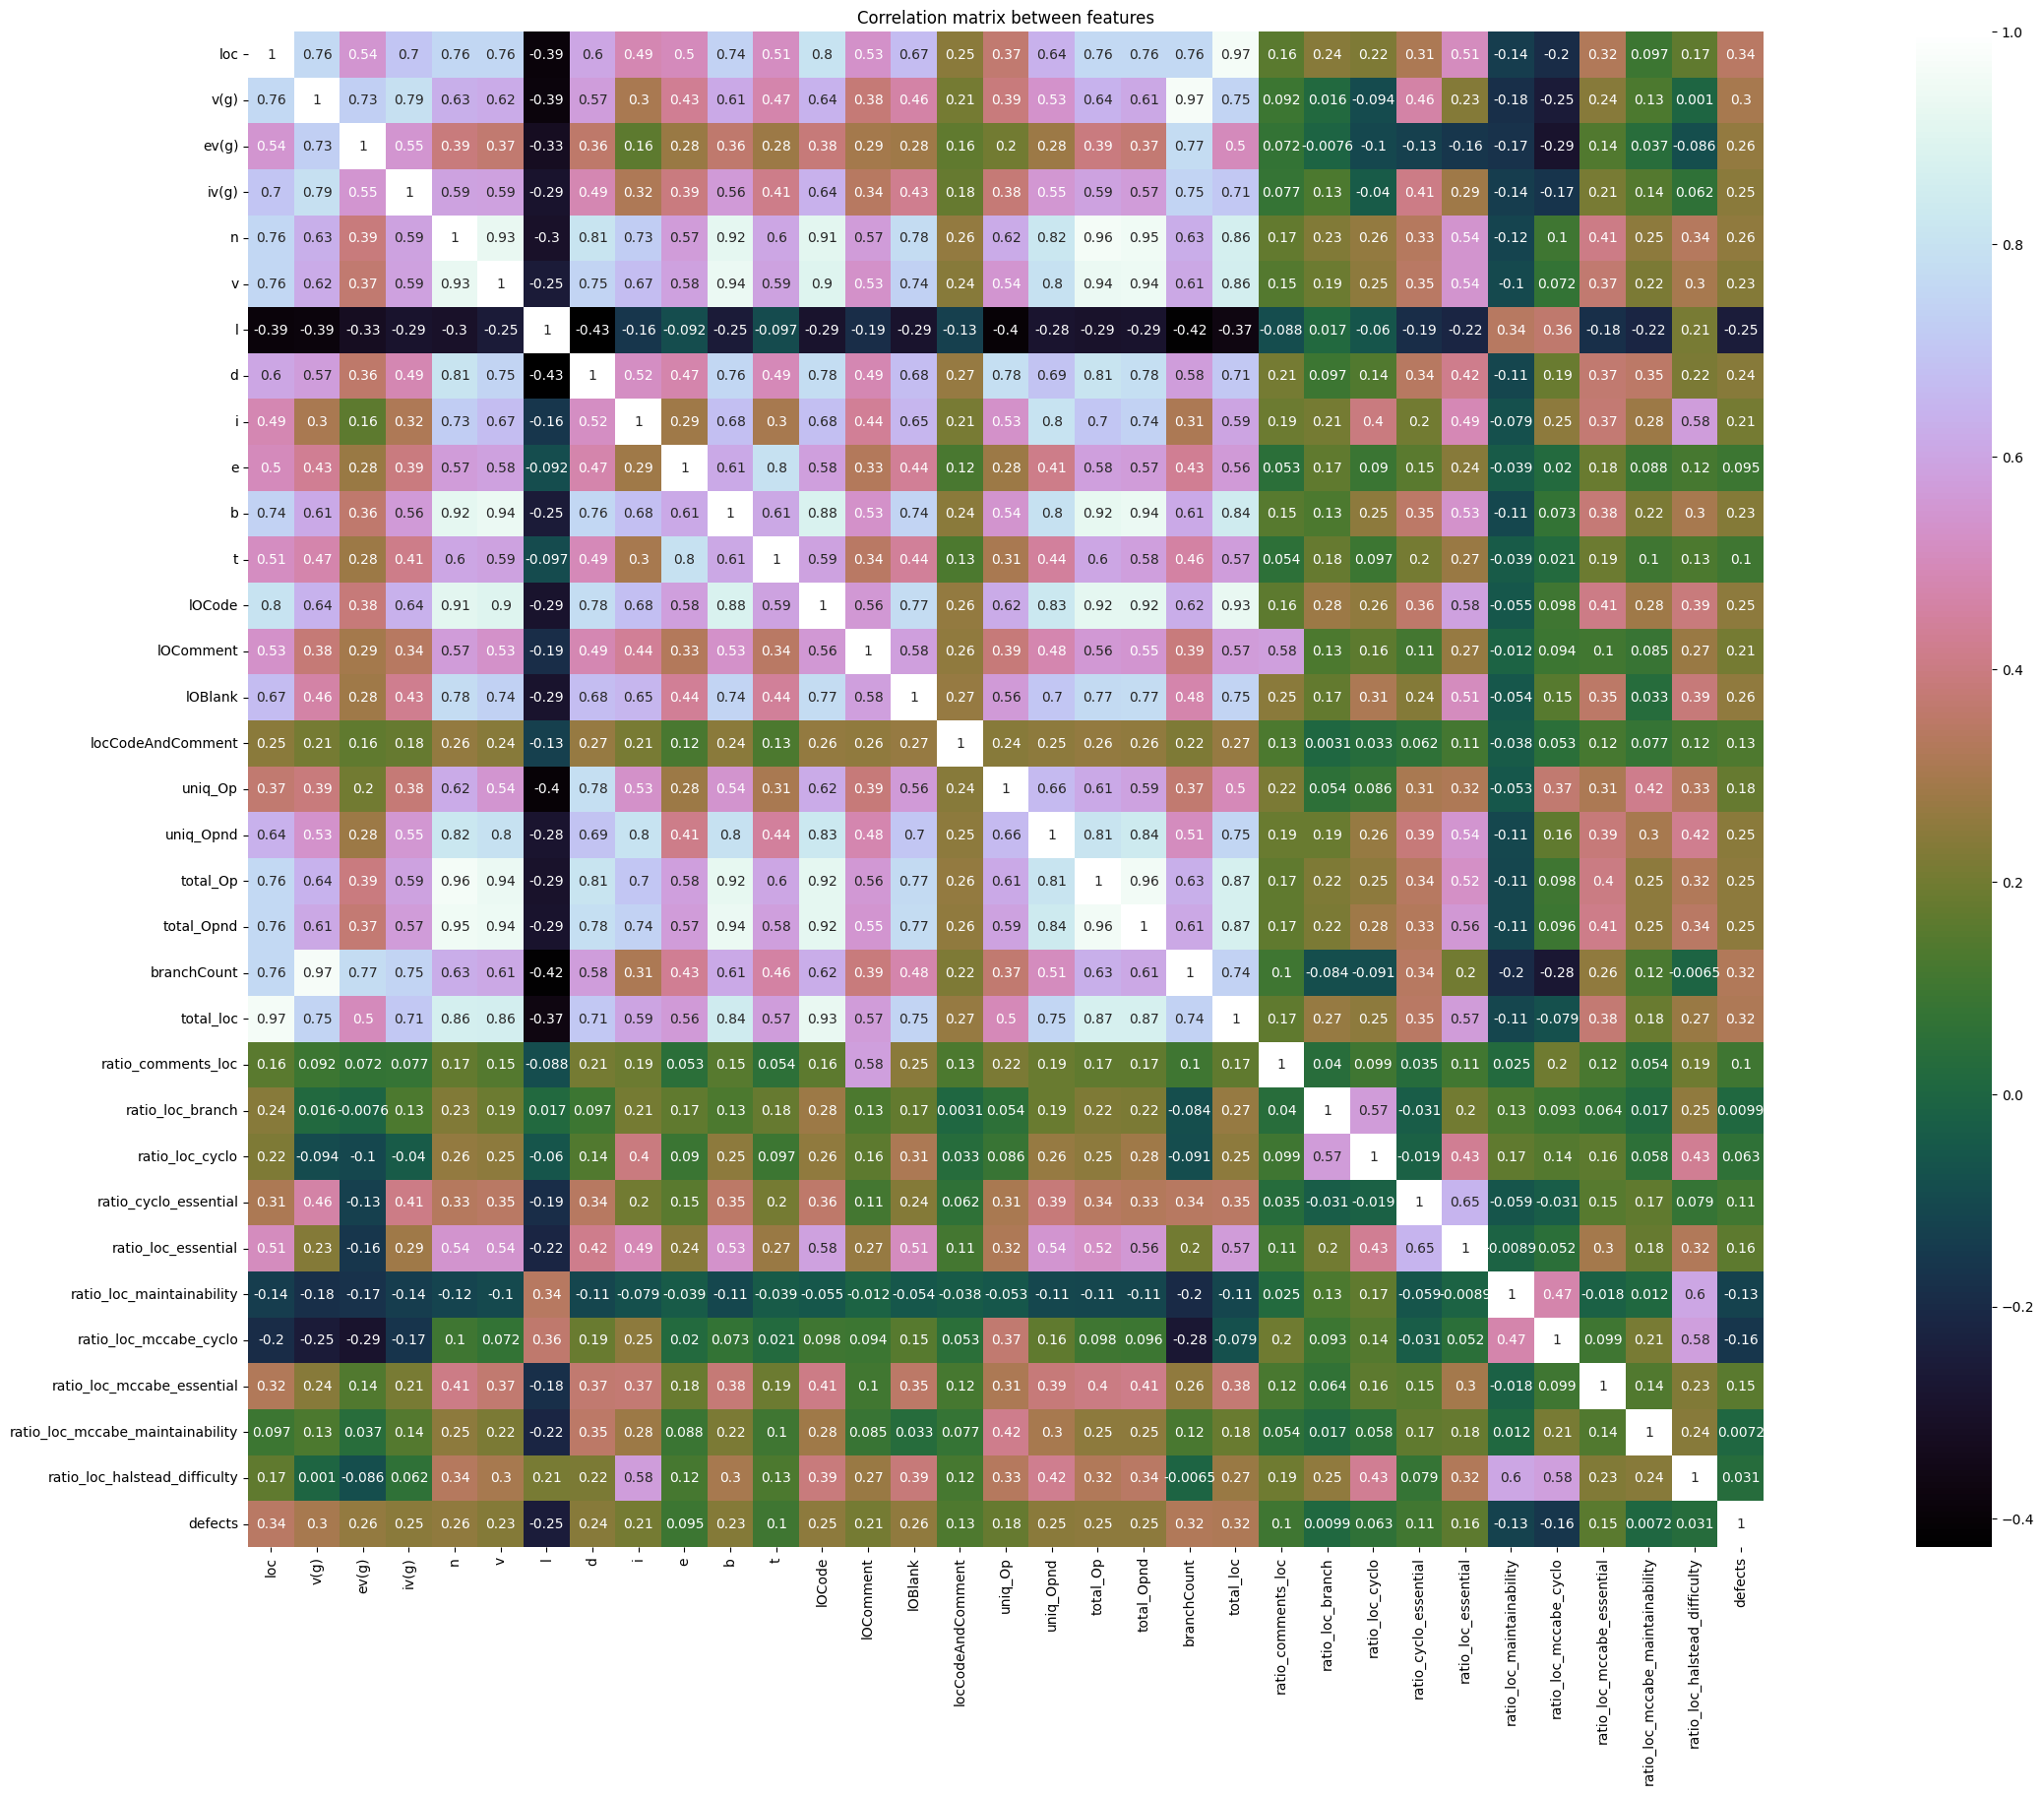

In [8]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(40,20))
sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title('Correlation matrix between features')
plt.show()

In [9]:
train_df = train_df.drop(['e'], axis=1)
train_df = train_df.drop(['t'], axis=1)
train_df = train_df.drop(['ratio_comments_loc'], axis=1)
train_df = train_df.drop(['ratio_loc_branch'], axis=1)
train_df = train_df.drop(['ratio_loc_cyclo'], axis=1)
train_df = train_df.drop(['ratio_loc_mccabe_maintainability'], axis=1)
train_df = train_df.drop(['ratio_loc_halstead_difficulty'], axis=1)
train_df = train_df.drop(['ratio_loc_maintainability'], axis=1)
train_df = train_df.drop(['ratio_loc_mccabe_cyclo'], axis=1)
train_df = train_df.drop(['ratio_cyclo_essential'], axis=1)
train_df = train_df.drop(['ratio_loc_essential'], axis=1)
train_df = train_df.drop(['ratio_loc_mccabe_essential'], axis=1)
train_df = train_df.drop(['locCodeAndComment'], axis=1)
train_df = train_df.drop(['total_loc'], axis=1)
train_df = train_df.drop(['uniq_Op'], axis=1)

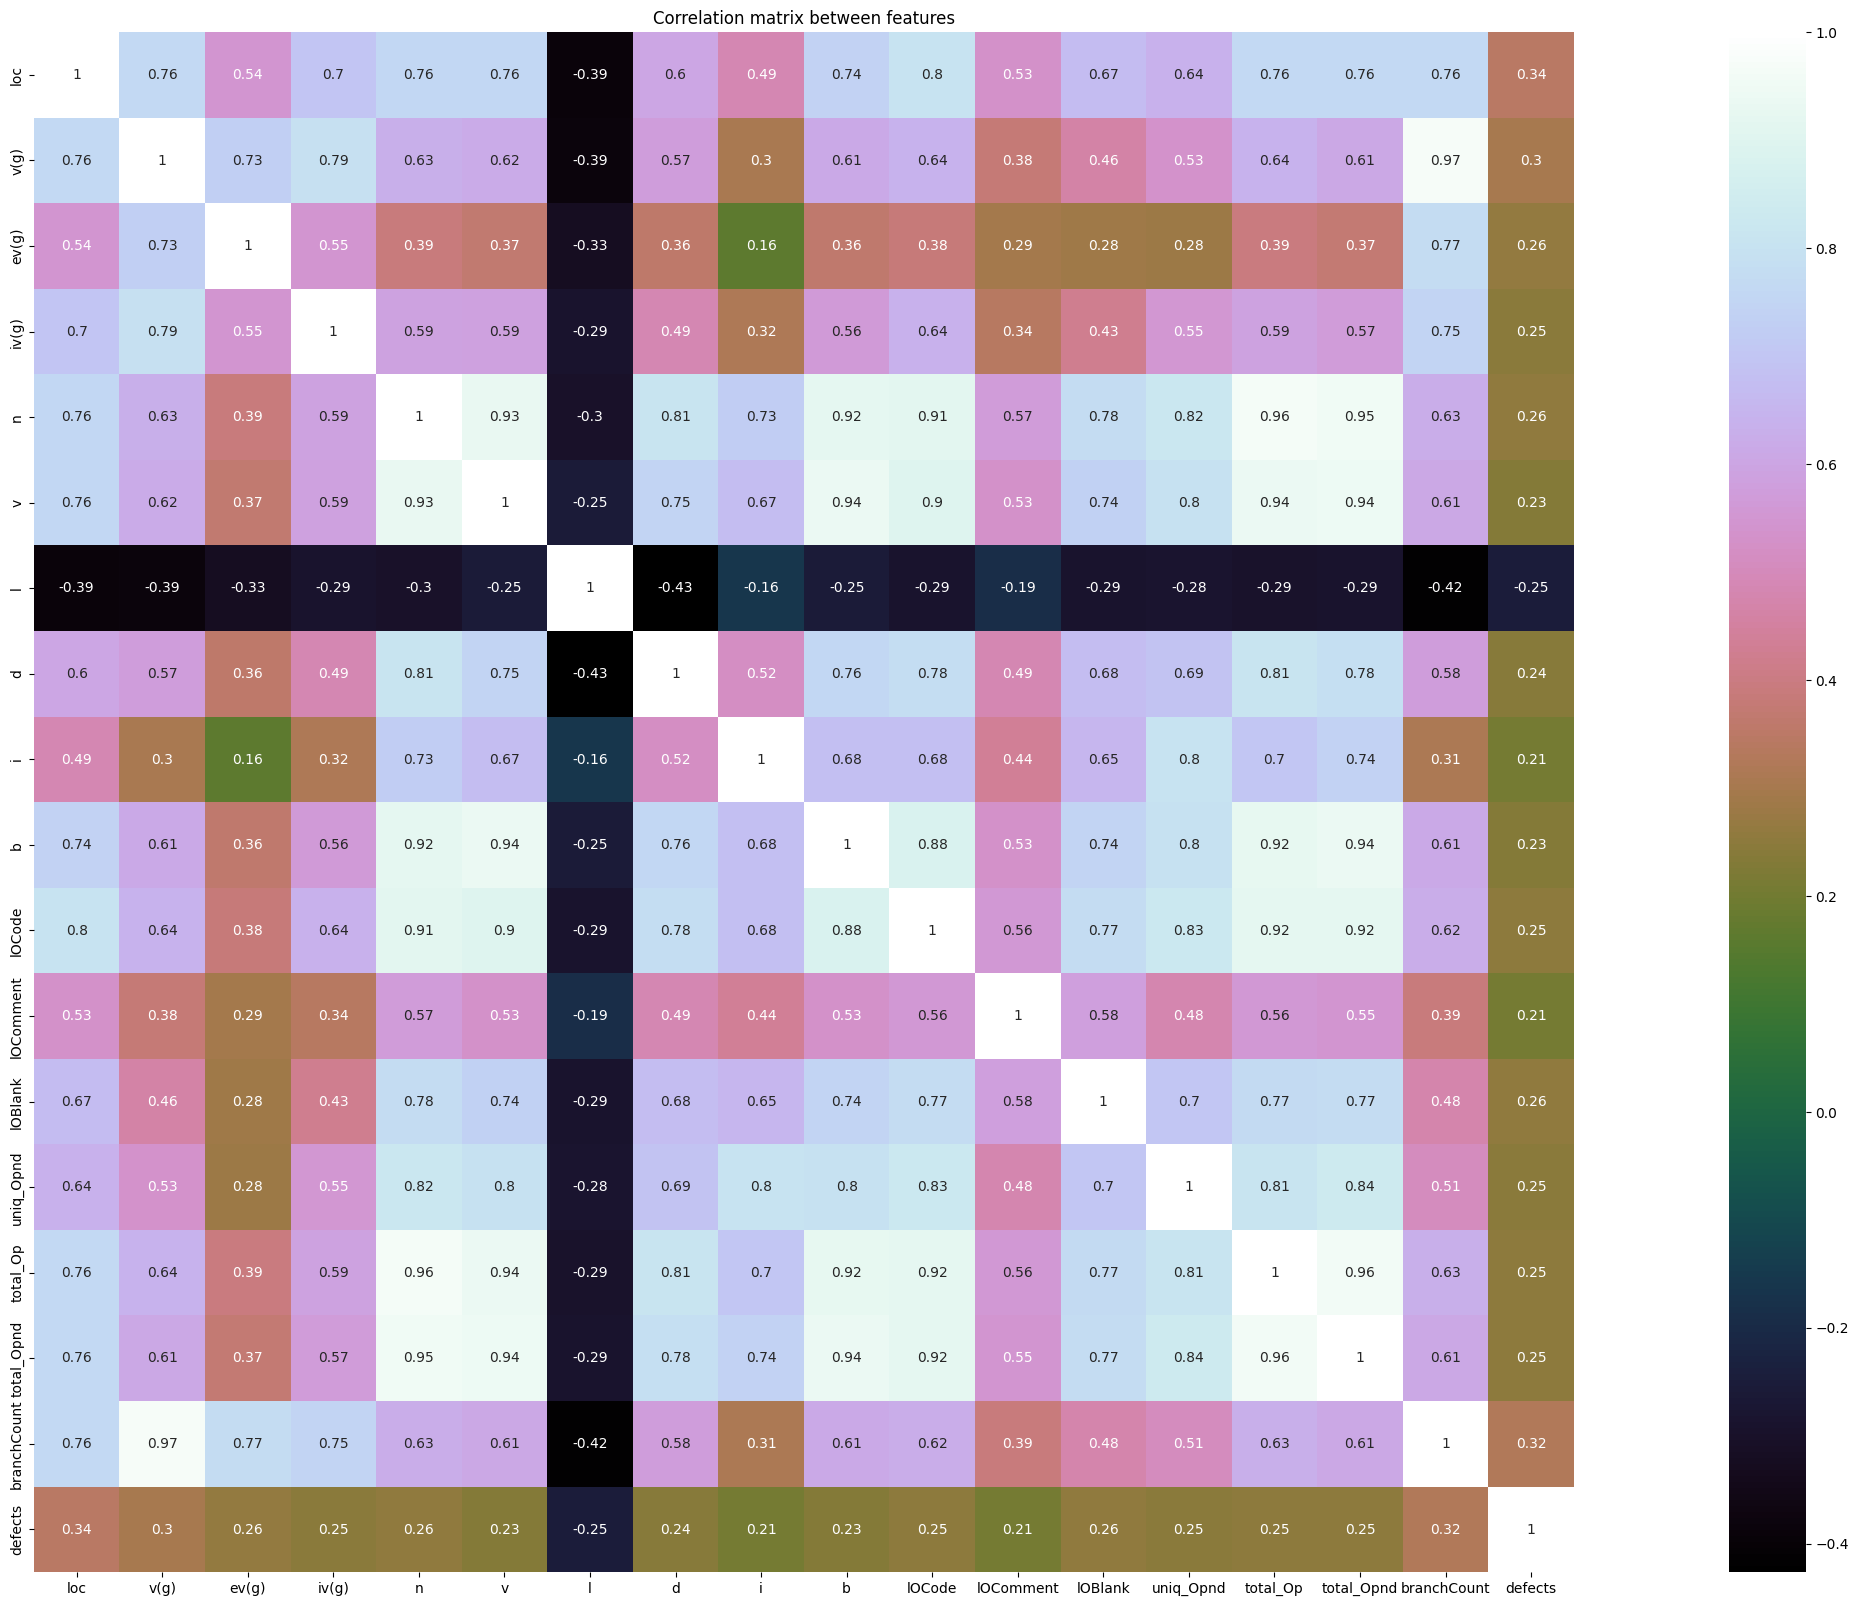

In [10]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(40,20))
sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title('Correlation matrix between features')
plt.show()

In [11]:
X_train = train_df.drop(columns=["defects"])

In [12]:
print("Preprocessing test data...")
test, _ = preprocess(test, test=True)

data = X_train.values
labels = y_train.values


Preprocessing test data...


In [13]:
test = test.drop(['e'], axis=1)
test = test.drop(['t'], axis=1)
test = test.drop(['ratio_comments_loc'], axis=1)
test = test.drop(['ratio_loc_branch'], axis=1)
test = test.drop(['ratio_loc_cyclo'], axis=1)
test = test.drop(['ratio_loc_mccabe_maintainability'], axis=1)
test = test.drop(['ratio_loc_halstead_difficulty'], axis=1)
test = test.drop(['ratio_loc_maintainability'], axis=1)
test = test.drop(['ratio_loc_mccabe_cyclo'], axis=1)
test = test.drop(['ratio_cyclo_essential'], axis=1)
test = test.drop(['ratio_loc_essential'], axis=1)
test = test.drop(['ratio_loc_mccabe_essential'], axis=1)
test = test.drop(['locCodeAndComment'], axis=1)
test = test.drop(['total_loc'], axis=1)
test = test.drop(['uniq_Op'], axis=1)

In [14]:
class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 128)
        self.fc3 = nn.Linear(128, 8)
        self.fc4 = nn.Linear(8, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))        
        return torch.sigmoid(self.fc4(x))

In [15]:
total_loss = 0.0
test_model = True
models = []

In [16]:
if test_model:
    for fold, (train_indices, val_indices) in enumerate(kf.split(data)):
        learning_rate = start_learning_rate
        print(f"Starting Fold {fold + 1}/{k_folds}...")
        X_train_fold, X_val_fold = data[train_indices], data[val_indices]
        y_train_fold, y_val_fold = labels[train_indices], labels[val_indices]

        train_dataset = CustomDataset(pd.DataFrame(X_train_fold), pd.Series(y_train_fold))
        val_dataset = CustomDataset(pd.DataFrame(X_val_fold), pd.Series(y_val_fold))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        print("Creating model...")
        net = Net(X_train_fold.shape[1]).to(device)

        # 4. Train model
        print("Training model...")
        criterion = nn.BCELoss()
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)

        for epoch in range(epochs):
            if (epoch + 1) % decrease_interval == 0:
                learning_rate = learning_rate * lr_decay
                optimizer = optim.Adam(net.parameters(), lr=learning_rate)
            print(f"Starting epoch {epoch + 1} with learning rate {learning_rate}...")
            running_loss = 0.0
            for inputs, labels_set in train_loader:
                inputs, labels_set = inputs.to(device), labels_set.to(device).unsqueeze(1) 

                optimizer.zero_grad()        
                outputs = net(inputs)
                loss = criterion(outputs, labels_set)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * len(inputs)  # Multiply by batch size to account for the mean loss
                inputs, labels_set = None, None  # Free memory

            print(f"Epoch: {epoch + 1}, Loss: {running_loss / len(train_loader.dataset):.3f}")


        # 5. Evaluate model
        print("Evaluating model...")
        net.eval()
        with torch.no_grad():
            running_loss = 0.0
            for inputs, labels_set in val_loader:
                inputs, labels_set = inputs.to(device), labels_set.to(device).unsqueeze(1)

                outputs = net(inputs)
                loss = criterion(outputs, labels_set)

                running_loss += loss.item() * len(inputs)

                inputs, labels_set = None, None  # Free memory

            print(f"Validation Loss: {running_loss / len(val_loader.dataset):.3f}")
            total_loss += running_loss / len(val_loader.dataset)
            
        models.append(net)

Starting Fold 1/20...
Creating model...
Training model...
Starting epoch 1 with learning rate 0.001...
Epoch: 1, Loss: 0.498
Starting epoch 2 with learning rate 0.001...
Epoch: 2, Loss: 0.440
Starting epoch 3 with learning rate 0.001...
Epoch: 3, Loss: 0.435
Starting epoch 4 with learning rate 0.0008...
Epoch: 4, Loss: 0.434
Starting epoch 5 with learning rate 0.0008...
Epoch: 5, Loss: 0.433
Starting epoch 6 with learning rate 0.0008...
Epoch: 6, Loss: 0.432
Starting epoch 7 with learning rate 0.0008...
Epoch: 7, Loss: 0.432
Starting epoch 8 with learning rate 0.00064...
Epoch: 8, Loss: 0.432
Starting epoch 9 with learning rate 0.00064...
Epoch: 9, Loss: 0.432
Starting epoch 10 with learning rate 0.00064...
Epoch: 10, Loss: 0.432
Starting epoch 11 with learning rate 0.00064...
Epoch: 11, Loss: 0.431
Starting epoch 12 with learning rate 0.0005120000000000001...
Epoch: 12, Loss: 0.431
Starting epoch 13 with learning rate 0.0005120000000000001...
Epoch: 13, Loss: 0.431
Starting epoch 14 w

In [17]:
print(f"Average Validation Loss: {total_loss / k_folds:.3f}")

Average Validation Loss: 0.431


In [18]:
# 6. Predict test data with each model and average the results
print("Predicting test data...")
test_dataset = CustomDataset(test, pd.Series(np.zeros(len(test))))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(test))

predictions = np.zeros(len(test))

print(len(predictions))

start_idx = 0
for model in models:
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            end_idx = start_idx + outputs.shape[0]  # Compute the ending index for this batch
            
            # Ensure we do not exceed the bounds of the 'predictions' array
            end_idx = min(end_idx, len(predictions))
            
            print(predictions[start_idx:end_idx].shape)
            print(outputs.squeeze(1).cpu().numpy().shape)
            
            predictions[start_idx:end_idx] += outputs.squeeze(1).cpu().numpy()
            
            start_idx = end_idx  # Update the starting index for the next batch
            
    start_idx = 0  # Reset for the next model if needed



predictions /= k_folds

Predicting test data...
67842
67842
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(1024,)
(102

In [19]:
# 7. Save predictions to CSV
print("Saving predictions...")
submission = pd.DataFrame({"id": test_ids, "defects": predictions})
submission.to_csv("data/prediction.csv", index=False)

Saving predictions...
